# MNIST Dataset with Softmax

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the MNIST dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [13]:
include("../src/NN.jl")
using NN
using PyPlot

[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


# Data Preparation

In this section, we will prepare the MNIST dataset to train the classifier. MNIST dataset contains 60000 grey-scale images, each of which has dimensions 28x28. We will flatten these data so that each image will become a vector of 784 dimensions, and the label will be between 0 and 9.

We also split the data into training, validation and testing sets. The corresponding ratio of those data sets are 80%, 10% and 10%.

In [14]:
include("../util/datasets.jl")
X, Y = mnistData(ttl=50000)
println("Raw Datset Sizes: $(size(X)), $(size(Y))")

train_set, test_set, validation_set = datasplit(X, Y)
trX, trY   = train_set
valX, valY = validation_set
teX, teY   = test_set
size(trX),size(trY),size(valX),size(valY),size(teX),size(teY)

Raw Datset Sizes: (50000,784), (50000,1)


((40000,784),(40000,1),(5000,784),(5000,1),(5000,784),(5000,1))

# Network Structure

We use a really really simple network structure that contains a single Dense Layer and a softmax cross entropy loss. The output of the classifier is defined as:

$$y = softmax(Wx+b)$$
where function $softmax(v)$ is defined as:

$$softmax(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

The loss function adapted the cross entropy function (which is a special case for KL-Divergence, when $p$, the ground truth probability is set to a hot vector):

$$\mathcal{L}=-\sum_{i}p_i\log{y_i}$$

The way to defined such classifier in JLNN is really simple:

In [15]:
function softmax_clf(batch_size = 100)
    layers = Layer[ 
        InputLayer((batch_size, 784))
        DenseLayer(10) 
    ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = softmax_clf()

NN.SequentialNet(NN.Layer[NN.InputLayer(true,(100,784),[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]),NN.DenseLayer(true,"Uniform",784,10,[-0.0827365 0.0513616 … 0.0934861 0.0377924; 0.11319 -0.0669254 … -0.0995565 0.0470647; … ; 0.0182307 0.00574418 … -0.0576202 -0.114537; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 -2.48274e-312; 0.0 1.39524e-320 … 0.0 -2.58883e-312; … ; 6.01745e175 NaN … -2.18566e-312 NaN; 5.66128e-315 -6.16092e-264 … 0.0 1.26481e-321],[0.0 7.42781e-313 … 0.0 0.0; 6.93934e-310 6.93934e-310 … 0.0 0.0; … ; 0.0 0.0 … 0.0 3.81783e256; 0.0 0.0 … 0.0 2.79003e179],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0

# Training and Optimizations

In this section, we train our network to learn the MNIST dataset. The network is consist of one FC layer, one cross-Entropy with soft max layer, and one sequential net. The training function we choose is the simple stochastic gradient descent.

In [16]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end
function train(net::SequentialNet, X, Y; 
    batch_size::Int = 100, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * getGradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        v_size = size(valX)[1]
        v_loss, v_accu = [],[]
        for i = 1:batch_size:v_size
            curr_v_loss, curr_v_pred = forward(net, valX[i:i+batch_size-1, :], valY[i:i+batch_size-1, :])
            curr_v_accu = get_corr(curr_v_pred, valY[i:i+batch_size-1, :]) / batch_size
            append!(v_loss, curr_v_loss)
            append!(v_accu, curr_v_accu)
        end

        append!(val_losses, mean(v_loss))
        append!(val_accu,   mean(v_accu))
        if epo % 10 == 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
            println("Validation accuracy : $(mean(v_accu))")
        end
        if verbose > 0
            println("Epo $(epo) has loss :$(mean(epo_loss))\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus,val_losses,val_accu
end

train (generic function with 1 method)

In [ ]:
net = softmax_clf()

losses,accus,val_losses,val_accus = train(net, trX, trY;
    ttl_epo = 100, lrSchedule = x -> 0.01, verbose=0)

figure(figsize=(12,6))
subplot(221)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(222)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()

subplot(223)
plot(1: length(val_losses), val_losses)
title("Validation Losses")
show()

subplot(224)
plot(1: length(val_accus), val_accus)
title("Validation Accuracy")
show()


Epo 10 has loss :0.4222736241388126		accuracy : 0.887275
Validation accuracy : 0.8871999999999997
Epo 20 has loss :0.3628045412046513		accuracy : 0.9003
Validation accuracy : 0.9011999999999998
Epo 30 has loss :0.33735793093200855		accuracy : 0.90695
Validation accuracy : 0.9074
Epo 40 has loss :0.3222125338107195		accuracy : 0.91095
Validation accuracy : 0.9103999999999998
Epo 50 has loss :0.3118187858749645		accuracy : 0.91405
Validation accuracy : 0.9121999999999999
Epo 60 has loss :0.30408630891852234		accuracy : 0.9161
Validation accuracy : 0.9136
Epo 70 has loss :0.29802446056635357		accuracy : 0.917525
Validation accuracy : 0.9148
Epo 80 has loss :0.2930938832505881		accuracy : 0.919075
Validation accuracy : 0.9162


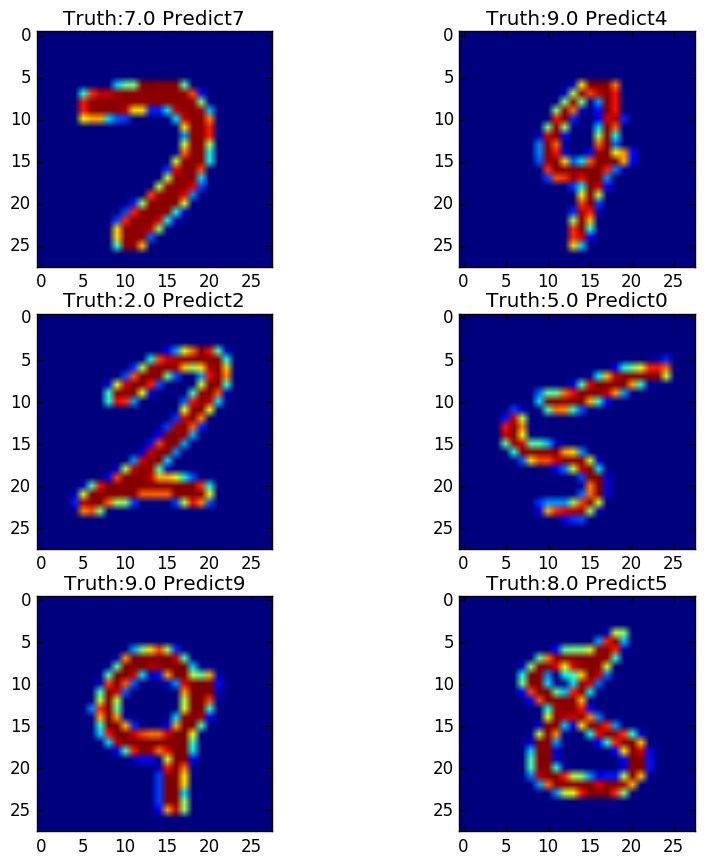

Testing Accuracy:92.2736


In [11]:
function test(teX, teY; batch_size = 100)
    ttl_corr, ttl = 0, 0
    right_idx = []
    wrong_idx = []
    ttl_pred = []
    N = size(teX)[1]
    for i = 1:batch_size:N
        x, y = teX[i:i+batch_size-1,:], teY[i:i+batch_size-1,:]
        _, pred = forward(net, x, y; deterministics =  true)
        for j = 1:batch_size
            ttl_corr += length(filter(i-> abs(pred[i] - y[i]) <  1e-5, 1:batch_size))
            if abs(pred[j] - y[j]) < 1e-5 # correct 
                ttl_corr += 1
                append!(right_idx, j)
            else # incorrect
                append!(wrong_idx, j)
            end
            ttl+=1
            append!(ttl_pred, pred[j])
        end
    end
    return ttl_pred, right_idx, wrong_idx, ttl_corr, N
end
pred, right_idx, wrong_idx, corr, N = test(teX, teY; batch_size = 100)
println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

# Use Gradient Descend to Generate Aversarial Images

In this section below, we will introduce how to use gradient descend on the input images to generate an adversarial training example that will differ from the original image by a really small difference.

The idea will be pretty simple: we will pick an image with that's originally classified to certain label, then we will propogate this image through the network compute the gradient of this image. Formally, suppose the image is $x$ and the network has output $f(x)$ with loss function $\mathcal{L}$, then we could use the simple backward pass to calculate $\frac{\partial \mathcal{L}}{\partial x}$. This value tells us the direction where we could move our images to increase the loss. Instead of updating the parameter of the layers, we will update the image to lower the loss:
$$x = x - \alpha \frac{\partial \mathcal{L}}{\partial x}$$

The surprising fact is that although the generated images almost remain the same, but the network will classify it incorrectly in to a different label.

Original Label:[6.0]	Target label:[9.0]


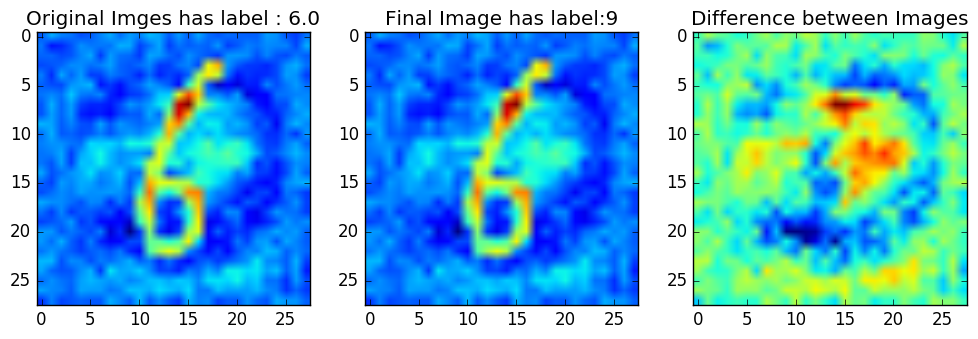

Average magtitude of the permutation:0.10996705044591108


In [12]:
idx   = convert(Int, ceil(rand() * size(trX)[1]))
alpha = 0.1
inpx  = trX[idx:idx,:]
t     = trY[idx:idx,:]

target = (t[1,:] + 3) % 10
println("Original Label:$(t[1,:])\tTarget label:$(target)")
t[1,:] = target
verbose = false
for i = 1:10000
    loss, _ = forward(net, inpx, t)
    dldx = backward(net, t)
    inpx -= alpha * dldx
    if i % 2000 == 1 && verbose
        println("Iteration $(i), loss:$(mean(loss)), dldx:$(sum(abs(dldx)))")
        figure(figsize=(2,2))
        imshow(reshape(inpx[1,:], 28,28))
        show()
    end
end

figure(figsize=(12,4))
subplot(131)
imshow(reshape(inpx, 28,28))
title("Original Imges has label : $(trY[idx])")

_, pred = forward(net, inpx, t)
subplot(132)
imshow(reshape(inpx[1,:], 28,28))
title("Final Image has label:$(pred[1])")

subplot(133)
imshow(reshape(inpx - trX[idx:idx,:], 28,28))
title("Difference between Images")
show()

println("Average magtitude of the permutation:$(mean(abs(inpx -trX[idx:idx,:])))")